# Compute the Compressibility inside the Nanopores

In [20]:
import numpy as np
from numpy import pi as π
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from scipy.signal import argrelextrema

import dgutils
from dgutils import colors as colortools
from numpy import pi as π
from wetting_utils import *
from collections import defaultdict
import matplotlib.transforms as mtransforms
from heprops import helium,potential
from pimcscripts import pimchelp
from scipy.constants import k as k_b



%config InlineBackend.figure_format = 'svg'
%matplotlib inline

## Load the scalar estimators (i.e. $\langle N \rangle$) from disk

In [21]:
L = 25 # Å
T = 2.0 # K
element = ['Ar','Cs']
R = np.array([6.0,8.0])

est = {}
μval = {}
N,ΔN = {},{}
N2, ΔN2 = {},{}

for el in element:
    for cR in R:
        est[lab(el,cR)] = pimchelp.PIMCResults(f'../data/pimc/{el}R{int(cR)}/estimator-u-reduce.dat')
        
        # we get a vector of μ values from the params
        μval[lab(el,cR)] = est[lab(el,cR)].data['u']

        # get #particles and #particles^2 for each element and radius
        N[lab(el,cR)] = est[lab(el,cR)].data['N']
        ΔN[lab(el,cR)] = est[lab(el,cR)].data['ΔN']
        N2[lab(el,cR)] = est[lab(el,cR)].data['N']
        ΔN2[lab(el,cR)] = est[lab(el,cR)].data['ΔN']        

## Investigate $N$ vs. $\mu$

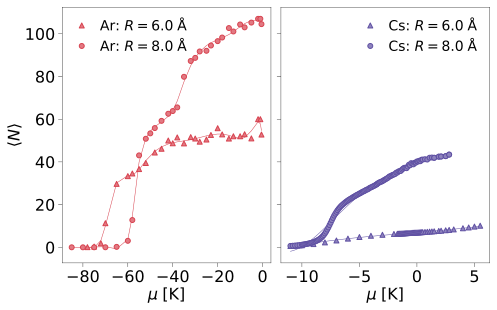

In [121]:
from scipy.ndimage import gaussian_filter1d
with plt.style.context('../include/notebook.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(1,2,figsize=(figsize[0],figsize[1]), sharex=False, sharey=True, constrained_layout=True)
    marker=['^','o']
    for iel,el in enumerate(element):
        col = element_colors[el]
        for iR,cR in enumerate(R):
            x,y,Δy = μval[lab(el,cR)], N[lab(el,cR)], ΔN[lab(el,cR)]

            idx = np.argsort(x)

            # Apply the sort to both arrays
            x = x[idx]
            y = y[idx]
            
            ax[iel].plot(x,y,marker=marker[iR], mec=col, mfc=colortools.get_alpha_hex(col,0.7), 
                             label=f'{el}: ' + f'$R = {cR:.1f}\;$' + r'${\rm \AA}$', color=col, lw=0, ms=5)
            
            from scipy.ndimage import gaussian_filter1d
            y_smooth = gaussian_filter1d(y, sigma=2)  # larger sigma = smoother
            #ax[iel].plot(x,y_smooth,'-', color=col, lw=0.5, zorder=-1)

            from scipy.signal import savgol_filter

            # window_length must be odd and > polyorder
            #y_smooth = savgol_filter(y, window_length=7, polyorder=3) 
            #ax[iel].plot(x,y_smooth,'--', color=col, lw=0.5, zorder=-1)

            from scipy.interpolate import UnivariateSpline
            spl = UnivariateSpline(x, y, k=3, s=2*len(x))  # increase/decrease s to smooth more/less
            y_smooth = spl(x)
            ax[iel].plot(x,y_smooth,'-', color=col, lw=0.5, zorder=-1)


        ax[iel].set_xlabel(r'$\mu\; [{\rm K}]$')
    ax[0].set_ylabel(r'$\langle N \rangle$')
    ax[0].legend()
    ax[1].legend()

## Take a numerical derivative of the data

/Users/agdelma/local/miniconda3/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1245: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/agdelma/local/miniconda3/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1246: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/agdelma/local/miniconda3/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1247: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/agdelma/local/miniconda3/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1253: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Users/agdelma/local/miniconda3/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1269: RuntimeWarning: divide by zero encountered in scalar divide
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple

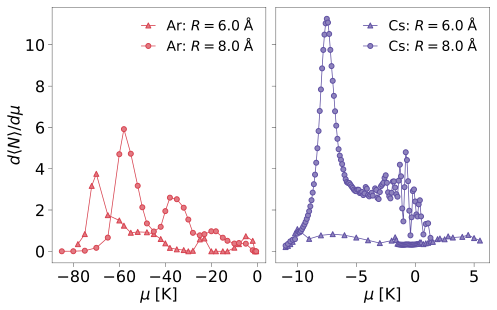

In [127]:
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import UnivariateSpline

with plt.style.context('../include/notebook.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(1,2,figsize=(figsize[0],figsize[1]), sharex=False, sharey=True, constrained_layout=True)
    marker=['^','o']
    for iel,el in enumerate(element):
        col = element_colors[el]
        for iR,cR in enumerate(R):
            x,y,Δy = μval[lab(el,cR)], N[lab(el,cR)], ΔN[lab(el,cR)]
            idx = np.argsort(x)

            # Apply the sort to both arrays
            x = x[idx]
            y = y[idx]
            
            y_smooth = gaussian_filter1d(y, sigma=1)  # larger sigma = smoother

            #spl = UnivariateSpline(x, y, k=3, s=len(x))  # increase/decrease s to smooth more/less
            #y_smooth = spl(x)
            dy = np.gradient(y_smooth,x)
            dy[dy < 0] = 0
            
            ax[iel].plot(x,dy,marker=marker[iR], mec=col, mfc=colortools.get_alpha_hex(col,0.7), 
                             label=f'{el}: ' + f'$R = {cR:.1f}\;$' + r'${\rm \AA}$', color=col, lw=0.75, ms=5)
        ax[iel].set_xlabel(r'$\mu\; [{\rm K}]$')
    ax[0].set_ylabel(r'$d \langle N \rangle / d\mu$')

    #ax[0].set_ylim(-0.2,11.5)
    ax[0].legend()
    ax[1].legend()

## Compute the compressibility using the trivial method

In [38]:
def compressibility(N,N2,volume=1.0,k_B=1.0,T=1.0):
    pf = volume/(k_B*T)
    return pf*np.abs((N2 - (N**2))/(N**2))

def y(μ,μmin,μmax):
    return (μ - μmin) / (μmax - μmin)

In [40]:
κ = {}
for el in element:
    for cR in R:
        V = π * cR**2 * L
        #κ[lab(el,cR)] = compressibility(N[lab(el,cR)],N2[lab(el,cR)],volume=V, T=T, k_B=k_b)
        κ[lab(el,cR)] = compressibility(N[lab(el,cR)],N2[lab(el,cR)], T=T)



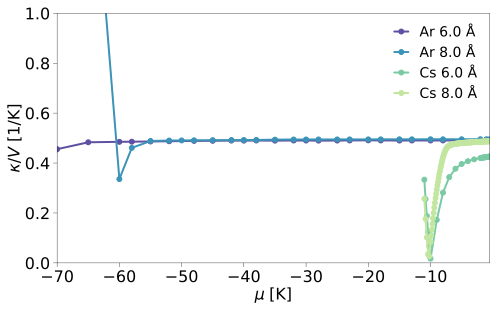

In [66]:
with plt.style.context('../include/notebook.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]), constrained_layout=True)
    #trans = mtransforms.ScaledTranslation(1/72, -9/72, fig.dpi_scale_trans)

    for el in element:
        for cR in R:
            _y = y(μval[lab(el,cR)],μval[lab(el,cR)].min(),μval[lab(el,cR)].max())
            ax.plot(μval[lab(el,cR)],κ[lab(el,cR)], label=lab(el,cR), marker='o')
    
    ax.set_xlabel(r'$\mu\; [{\rm K}]$') 
    ax.set_ylabel(r'$\kappa/V$ [1/K]')
    ax.set_xlim(-70,-0.5)
    ax.set_ylim(0,1)
    ax.legend()

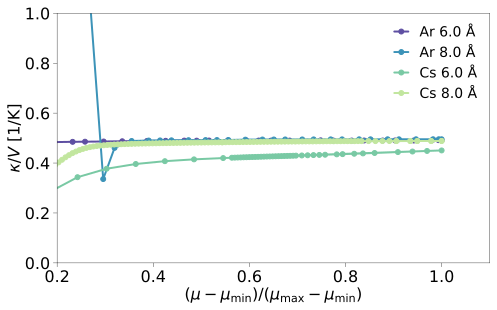

In [61]:
with plt.style.context('../include/notebook.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]), constrained_layout=True)
    #trans = mtransforms.ScaledTranslation(1/72, -9/72, fig.dpi_scale_trans)

    for el in element:
        for cR in R:
            _y = y(μval[lab(el,cR)],μval[lab(el,cR)].min(),μval[lab(el,cR)].max())
            ax.plot(_y,κ[lab(el,cR)], label=lab(el,cR), marker='o')
    
    ax.set_xlabel(r'$(\mu - \mu_{\rm min})/(\mu_{\rm max}-\mu_{\rm min})$') 
    ax.set_ylabel(r'$\kappa/V$ [1/K]')
    ax.set_xlim(0.2,1.1)
    ax.set_ylim(0,1)
    ax.legend()

In [ ]:
with plt.style.context('../include/aps.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]), constrained_layout=True)
    #trans = mtransforms.ScaledTranslation(1/72, -9/72, fig.dpi_scale_trans)

### This is from Nathan's erorr analysis package

We will need the raw bins to use this

In [ ]:
import erroranalysis as ea
import numpy as np
from scipy.constants import k as k_b

skip = 6000 # Skip some measurements

# Values specific to the argon in MCM-41 GCMC simulations
box_volume = 139357.3925 #\AA^3
volume = box_volume*((1e-10)**3)
temperature = 87.35 #K

# Load the GCMC data 
fn = "examples/argon_MCM41_-12.68.out.prp"
_data = np.genfromtxt(fn,names=True,skip_header=1)

#Calculate average compressibility and error using jackknife method
κ_avg, κ_err = ea.jackknife_on_function( compressibility,
                                         _data["Nmols_2"][skip:],
                                         _data["Nmols_2"][skip:]**2,
                                         volume=volume,
                                         k_B=k_b,
                                         T=temperature)
print("κ_avg = {:.5e}".format(κ_avg))
print("κ_err = {:.5e}".format(κ_err))

In [5]:
f2 = open('../data/pimc/CsR8/estimator-u-reduce.dat','r')
lines = f2.readlines()
u = np.array([])
N = np.array([])
N2 = np.array([])
rho = np.array([])
delN = np.array([])
for line in lines[1:]:
    p = line.split()
    u = np.append(u,float(p[0]))
    N = np.append(N,float(p[19]))
    N2 = np.append(N2, float(p[21]))
    rho = np.append(rho, float(p[23]))
    delN = np.append(delN,float(p[20]))
f2.close()
ind = np.argsort(u)
uCs = u[ind]
N = N[ind]
N2 = N2[ind]
rho = rho[ind]
delN = delN[ind]
kCs = np.divide((N2 - N**2),N**2)
kCs = kCs/(2)
kCs = kCs/max(kCs)
#print(kCs)
PCs = hel.pressure(uCs,2)
PCsmax = max(PCs)
PCsmin = min(PCs)
PCsPlot = (PCs - PCsmin)/PCsmax
#u = np.delete(u,4)
#k = np.delete(k,4)
f2 = open('../data/pimc/ArR8/estimator-u-reduce.dat','r')
lines = f2.readlines()
u = np.array([])
N = np.array([])
N2 = np.array([])
rho = np.array([])
delN = np.array([])
for line in lines[1:]:
    p = line.split()
    u = np.append(u,float(p[0]))
    N = np.append(N,float(p[19]))
    N2 = np.append(N2, float(p[21]))
    rho = np.append(rho, float(p[23]))
    delN = np.append(delN,float(p[20]))
f2.close()
ind = np.argsort(u)
uAr = u[ind]
uAr = np.delete(uAr,8)
N = N[ind]
N = np.delete(N,8)
#print(N)
N2 = N2[ind]
N2 = np.delete(N2,8)
#print(N2)
rho = rho[ind]
delN = delN[ind]
kAr = np.divide((N2 - N**2),N**2)
#print(N2[8] - N[8]**2)
kAr = kAr/(2)
kAr = kAr/max(kAr)
#print(kAr)
PAr = hel.pressure(uAr,2)
PArmax = max(PAr)
PArmin = min(PAr)
PArPlot = (PAr - PArmin)/PArmax
print(PArPlot)
#print(max(PArPlot))

f2 = open('../data/pimc/MgR8/estimator-u-reduce.dat','r')
lines = f2.readlines()
u = np.array([])
N = np.array([])
N2 = np.array([])
rho = np.array([])
delN = np.array([])
for line in lines[1:]:
    p = line.split()
    u = np.append(u,float(p[0]))
    N = np.append(N,float(p[19]))
    N2 = np.append(N2, float(p[21]))
    rho = np.append(rho, float(p[23]))
    delN = np.append(delN,float(p[20]))
f2.close()
ind = np.argsort(u)
uMg = u[ind]
N = N[ind]
N2 = N2[ind]
rho = rho[ind]
delN = delN[ind]
kMg = np.divide((N2 - N**2),N**2)
kMg = kMg/(2)
kMg = kMg/max(kMg)
PMg = hel.pressure(uMg,2)
PMgmax = max(PMg)
PMgmin = min(PMg)
PMgPlot = (PMg - PMgmin)/PMgmax

[0.00000000e+00 2.46178884e-18 3.24525165e-17 3.97814376e-16
 4.84883302e-15 5.90733408e-14 1.60578367e-13 7.19663079e-13
 8.76729357e-12 2.38319752e-11 1.06807503e-10 4.78678022e-10
 1.30118177e-09 3.53697878e-09 1.58516396e-08 7.10421280e-08
 1.93112575e-07 5.24934770e-07 2.35260347e-06 6.39509362e-06
 2.86621632e-05 7.79199063e-05 3.49411971e-04 9.50997735e-04
 4.29163691e-03 1.18436067e-02 5.74665676e-02 3.45666652e-01
 6.91226865e-01 1.00000000e+00]


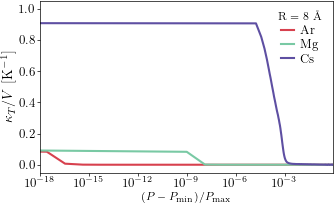

In [6]:
with plt.style.context('aps'):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(figsize=(figsize[0],figsize[1]), constrained_layout=True)
    ax.semilogx(PArPlot,kAr,label=r'Ar',color='#D7414E')
    ax.semilogx(PMgPlot,kMg,label=r'Mg',color='#79C9A4')
    ax.semilogx(PCsPlot,kCs,label=r'Cs',color='#5E4FA2')
    ax.set_ylabel(r'$\kappa_T/V \text{ } [\rm K^{-1}]$',fontsize=10)
    ax.set_xlabel(r'$(P - P_{\rm min})/P_{\rm max}$')
    ax.set_xlim(1e-18,0.9)
    plt.legend(title="R = 8 Å",handlelength=1)
    #plt.show()
    plt.savefig('../figures/KvsPR8.pdf')